In [69]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [70]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

In [71]:
import matplotlib.pyplot as plt

In [88]:
import variant_orbits
import scheduling
import detection_probability
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)

<module 'detection_probability' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/detection_probability.py'>

In [4]:
%config InlineBackend.figure_format = 'retina'

# Main run

In [384]:
%%time
probs, will_be_detected = detection_probability.get_detection_probabilities(night_start=0)

000009F 0.748
00000EE 0.878
00000CC 0.0
0000240 0.484
0000243 0.842
000022D 0.438
00008A3 0.854
000095E 0.0
0000966 0.588
00009E5 0.86
0000AE6 0.87
0000AE9 0.766
0000AFE 0.784
0000B28 0.834
0000C78 0.758
0000CE0 0.824
0000D5E 0.0
0000DBE 0.852
0000E6C 0.758
000029F 0.0
000031A 0.036
000050F 0.0
0000686 0.0
000075D 0.328
0000791 0.0
0000F47 0.84
0001796 0.0
0001855 0.53
00018A1 0.0
0001914 0.842
0001C31 0.852
000121A 0.846
0001270 0.132
00012DC 0.806
00013AB 0.866
00013B3 0.794
00014B6 0.844
000156C 0.724
0001611 0.808
0001675 0.864
00016DE 0.83
0001F6F 0.808
0002604 0.834
000267A 0.87
0002774 0.706
0002844 0.792
000286D 0.414
000296A 0.826
00029AE 0.242
0002AAE 0.472
0001F98 0.04
0002069 0.146
00022F2 0.88
0002485 0.85
00035AA 0.814
0003427 0.842
000435B 0.158
00043CB 0.832
00044F6 0.722
00045CB 0.806
000465A 0.054
0004719 0.844
0004767 0.796
00047D5 0.832
000488B 0.0
00048D9 0.878
0003D7B 0.856
0003E54 0.0
0003F78 0.0
0003FDB 0.0
00040EB 0.85
00042A7 0.0
00049DD 0.872
0004A0F 0.62
000

In [58]:
probs = np.load("probs_test.npy")

In [59]:
findable_ids = np.load("neo_findable_first_15.npy", allow_pickle=True)
will_be_detected = np.isin(unique_objs, findable_ids)

In [60]:
for i in range(len(probs)):
    print(probs[i], will_be_detected[i])

0.748 False
0.878 True
0.0 False
0.484 True
0.842 True
0.438 False
0.854 True
0.0 False
0.588 True
0.86 True
0.87 True
0.766 False
0.784 True
0.834 True
0.758 False
0.824 True
0.0 False
0.852 True
0.758 False
0.0 False
0.036 False
0.0 False
0.0 False
0.328 True
0.0 True
0.84 True
0.0 False
0.53 True
0.0 False
0.842 False
0.852 True
0.846 True
0.132 False
0.806 True
0.866 True
0.794 True
0.844 True
0.724 True
0.808 True
0.864 True
0.83 True
0.808 True
0.834 True
0.87 True
0.706 True
0.792 False
0.414 False
0.826 True
0.242 False
0.472 False
0.04 True
0.146 False
0.88 True
0.85 False
0.814 True
0.842 False
0.158 False
0.832 False
0.722 True
0.806 False
0.054 False
0.844 False
0.796 False
0.832 True
0.0 False
0.878 True
0.856 True
0.0 False
0.0 False
0.0 True
0.85 False
0.0 False
0.872 False
0.62 True
0.854 False
0.012 False
0.846 False
0.0 False
0.718 True
0.03 False
0.744 True
0.868 True
0.794 False
0.852 False
0.766 False
0.772 True
0.85 False
0.208 False
0.246 False
0.64 False
0.4 Tru

In [61]:
threshold = 0.5
correct_detectable = len(probs[np.logical_and(probs < threshold, np.logical_not(will_be_detected))])
correct_undetectable = len(probs[np.logical_and(probs >= threshold, will_be_detected)])
incorrect_detectable = len(probs[np.logical_and(probs < threshold, will_be_detected)])
incorrect_undetectable = len(probs[np.logical_and(probs >= threshold, np.logical_not(will_be_detected))])


print("Of the 179 objects, we classified")
print(f"  {correct_detectable + correct_undetectable} correctly")
print(f"    {correct_detectable} were detectable")
print(f"    {correct_undetectable} were undetectable")
print(f"  {incorrect_detectable + incorrect_undetectable} incorrectly")
print(f"    {incorrect_detectable} were detectable")
print(f"    {incorrect_undetectable} were undetectable")

Of the 179 objects, we classified
  119 correctly
    50 were detectable
    69 were undetectable
  60 incorrectly
    9 were detectable
    51 were undetectable


(0.0, 1.0)

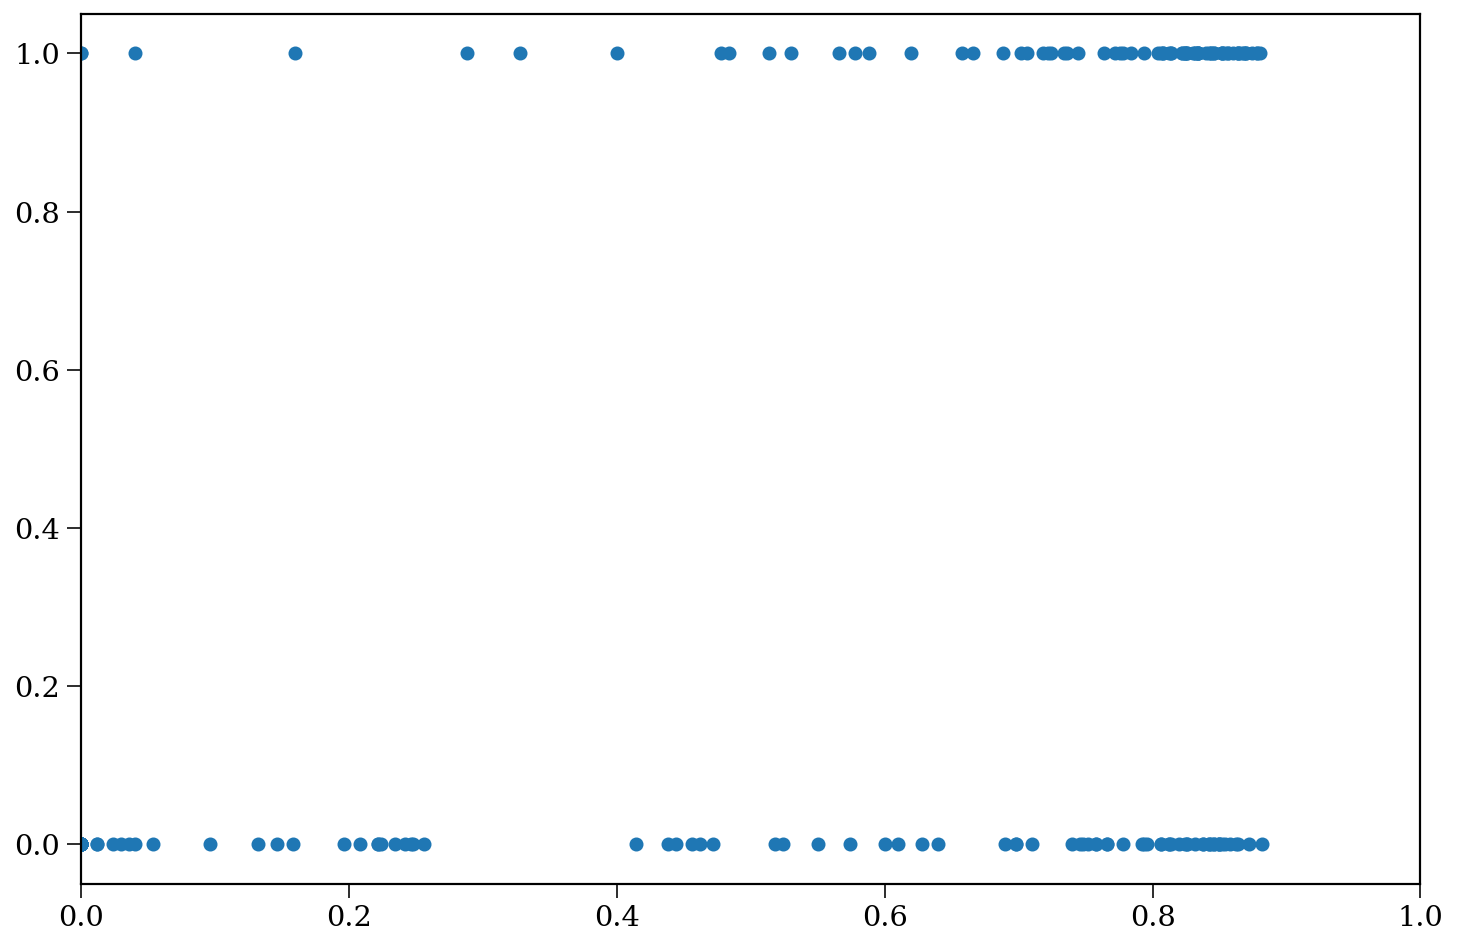

In [65]:
plt.scatter(probs, will_be_detected.astype(int))
plt.xlim(0, 1)

(array([30.,  4., 10.,  0.,  2.,  6.,  4.,  5., 11., 29.]),
 array([0.    , 0.0882, 0.1764, 0.2646, 0.3528, 0.441 , 0.5292, 0.6174,
        0.7056, 0.7938, 0.882 ]),
 <BarContainer object of 10 artists>)

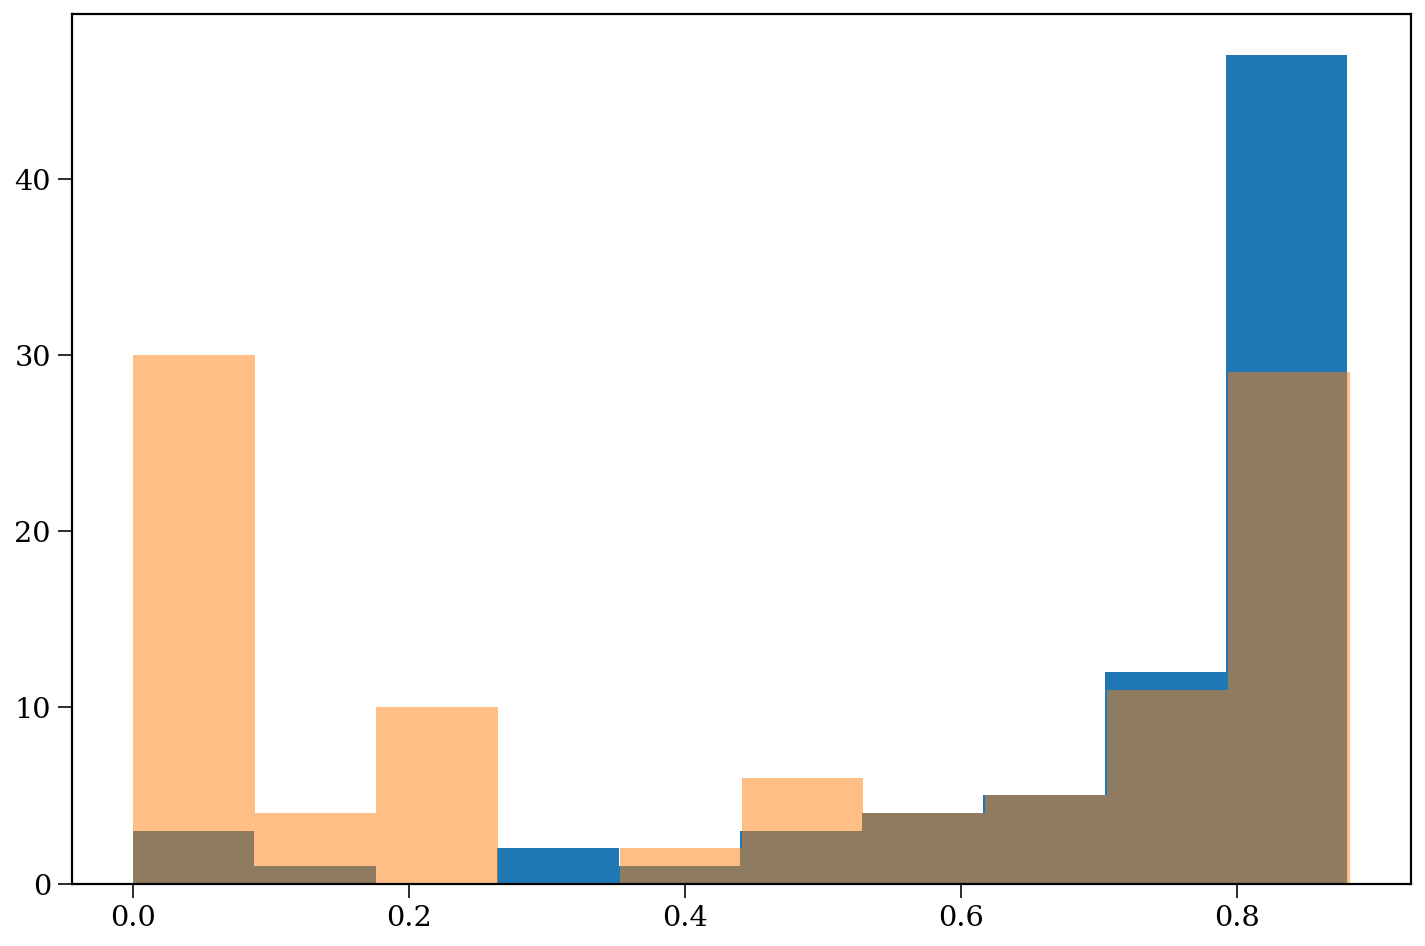

In [77]:
plt.hist(probs[will_be_detected])
plt.hist(probs[np.logical_not(will_be_detected)], alpha=0.5)

### okay let's investigate some wrong ones

In [406]:
unique_objs[np.logical_and(probs >= threshold, np.logical_not(will_be_detected))]

array(['000009F', '0000AE9', '0000C78', '0000E6C', '0001914', '0002844',
       '0002485', '0003427', '00043CB', '00045CB', '0004719', '0004767',
       '00040EB', '00049DD', '0004B0A', '000565A', '00050B8', '0005147',
       '0005165', '000605E', '000630C', '0007274', '0007526', '00080A1',
       '00083EC', '00090F0', '00261EE', '0025952', '00314C9', '00331AB',
       '0009448', '0009AEB', '0009776', '00098B7', '000999C', '000AE33',
       '000A585', '000C9BE', '000D2BB', '000DB8A', '000F4B6', '000F76C',
       '000EDF4', '000F159', '000FFEA', '001867F', '001892E', '001D1A5',
       '001CC02', '001EFCE', '003DF55'], dtype=object)

In [167]:
night_start = 0
path = "../neocp/neo/"
detection_window = 15
min_nights = 3

night_list = list(range(night_start, night_start + detection_window))
schedule = scheduling.get_LSST_schedule(night=(night_start, night_start + detection_window - 1))

# offset the schedule by one row and re-merge to get the previous night column
shifted = schedule.shift()
shifted = shifted.drop("observationStartMJD", axis=1)
shifted = shifted.rename(columns={"fieldRA": "previousFieldRA", "fieldDec": "previousFieldDec",
                                  "night": "previousNight"})
full_schedule = pd.merge(schedule, shifted, left_index=True, right_index=True)

# calculate the length of each night in days
night_lengths = np.zeros(detection_window)
for i, night in enumerate(night_list):
    mask = full_schedule["night"] == night

    # ignore nights that have no observations (bad weather/downtime)
    if not full_schedule[mask].empty:
        night_lengths[i] = full_schedule[mask].iloc[-1]["observationStartMJD"]\
            - full_schedule[mask].iloc[0]["observationStartMJD"]

# get the first/last visit from each night
night_transition = full_schedule["night"] != full_schedule["previousNight"]
first_visit_times = full_schedule[night_transition]["observationStartMJD"].values

last_times_ind = np.array(list(full_schedule[night_transition].index[1:]) + [len(full_schedule)]) - 1
last_visit_times = full_schedule.loc[last_times_ind]["observationStartMJD"].values

file = 0
visit_file = pd.read_hdf(path + f"filtered_visit_{file:03d}.h5")

# get the objects from the night
sorted_obs = visit_file[visit_file["night"] == night_start].sort_values(["ObjID", "FieldMJD"])
unique_objs = sorted_obs["hex_id"].unique()

In [174]:
np.sort(np.concatenate([first_visit_times, last_visit_times]))

array([59639.00902255, 59639.40249862, 59640.00819173, 59640.40319137,
       59648.00139754, 59648.4074114 , 59649.20779192, 59649.40779794,
       59649.99931048, 59650.40821104, 59650.99789811, 59651.40898884,
       59651.99793753, 59652.40939485, 59652.99596454, 59653.41013877])

In [169]:
night_lengths

array([0.39347607, 0.39499964, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.40601386,
       0.20000602, 0.40890057, 0.41109072, 0.41145731, 0.41417423])

In [168]:
last_visit_times - first_visit_times

array([0.39347607, 0.39499964, 0.40601386, 0.20000602, 0.40890057,
       0.41109072, 0.41145731, 0.41417423])

In [10]:
unique_findable_neo_hex_ids = np.load("neo_findable_first_15.npy", allow_pickle=True)
will_be_detected = np.isin(unique_objs, unique_findable_neo_hex_ids)

In [207]:
import variant_orbits
import scheduling
import detection_probability
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)

<module 'detection_probability' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/detection_probability.py'>

In [200]:
%%time
prob, reachable_schedule, orbits = detection_probability.probability_from_id("00090F0", sorted_obs,
                                                                             np.logspace(-1, 1.1, 10) * u.AU,
                                                                             np.linspace(-50, 10, 3) * u.km / u.s,
                                                                             first_visit_times, full_schedule,
                                                                             night_lengths, night_list)

CPU times: user 891 ms, sys: 29.2 s, total: 30.1 s
Wall time: 34.7 s


In [201]:
%%time
orbits, truth = detection_probability.first_last_pos_from_id("00090F0", sorted_obs, s3m_cart,
                                                             np.logspace(-1, 1.1, 5) * u.AU,
                                                             np.linspace(-50, 10, 3) * u.km / u.s,
                                                             first_visit_times, last_visit_times)

In [208]:
interact(detection_probability.plot_LSST_schedule_with_orbits,
         schedule=fixed(schedule), reachable_schedule=fixed(reachable_schedule),
         orbits=fixed(orbits), truth=fixed(truth),
         night=widgets.IntSlider(min=0, max=14, step=1, value=11, continuous_update=False),
         colour_by=widgets.Combobox(
            value='distance',
            options=['distance', 'orbit'],
            description='Colour by:',
            ensure_option=True,
            disabled=False),
         lims=widgets.Combobox(
            value='full_schedule',
            options=['orbits', 'full_schedule', 'schedule', 'reachable'],
            description='Axes limits:',
            ensure_option=True,
            disabled=False),
         field_radius=fixed(2.1),
         s=widgets.IntSlider(min=1, max=25, step=1, value=15, continuous_update=False),
        )

interactive(children=(IntSlider(value=11, continuous_update=False, description='night', max=14), Combobox(valu…

<function detection_probability.plot_LSST_schedule_with_orbits(schedule, reachable_schedule, orbits, truth, night, colour_by='distance', lims='full_schedule', field_radius=2.1, s=5)>

# Where actually is it?

In [123]:
s3m_cart = pd.read_hdf("../catalogues/s3m_cart.h5")

In [175]:
hybrid_cart = pd.read_hdf("../catalogues/hybrid_cart.h5")

In [126]:
s3m_cart["hex_id"] = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m_cart.index.values))])

In [176]:
hybrid_cart["hex_id"] = np.array(['{:07X}'.format(num) for num in np.arange(len(hybrid_cart.index.values))])

In [127]:
s3m_cart

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S0000001a,0.0,-1.497621,-2.219998,-0.121434,0.005838,-0.006255,0.001226,1.0,54466.0,3.0,10.315000,0.15,0000000
S0000002a,1.0,-0.867436,2.369810,-0.317870,-0.006430,-0.009964,0.003795,1.0,54466.0,3.0,10.818000,0.15,0000001
S0000003a,2.0,-0.957813,0.466564,0.193313,0.002716,-0.019129,-0.001788,1.0,54466.0,3.0,11.175000,0.15,0000002
S0000004a,3.0,-4.268592,-0.745253,1.259818,0.003616,-0.002620,-0.000604,1.0,54466.0,3.0,11.452000,0.15,0000003
S0000005a,4.0,-3.545760,-0.411177,-1.184829,-0.003123,-0.004855,-0.002361,1.0,54466.0,3.0,11.678000,0.15,0000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEN10895,14402282.0,-17.031867,14.273743,-11.013700,-0.003131,-0.000959,0.001550,1.0,59215.0,3.0,19.645034,0.15,0DBC2EA
CEN10896,14402283.0,4.305471,15.438098,-12.212285,-0.003330,0.002235,0.001598,1.0,59215.0,3.0,11.600137,0.15,0DBC2EB
CEN10897,14402284.0,-14.239609,-18.592683,4.889858,0.001227,-0.002684,-0.002301,1.0,59215.0,3.0,19.503685,0.15,0DBC2EC
CEN10898,14402285.0,9.208982,-12.435805,-15.468118,0.003680,0.001658,-0.000151,1.0,59215.0,3.0,17.060558,0.15,0DBC2ED


In [181]:
'{:07X}'.format("S0000s16a")

ValueError: Unknown format code 'X' for object of type 'str'

In [177]:
hybrid_cart[hybrid_cart["hex_id"] == "001867F"]

,id,x,y,z,vx,vy,vz,t_0,H,g,hex_id
S0000s16a,99967.0,-2.485441,-1.963401,-0.27212,0.006115,-0.002379,0.000455,59639.0,23.832,0.15,001867F


In [179]:
item = s3m_cart[s3m_cart["hex_id"] == "001867F"]
item

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S0000qIQa,99967.0,-0.505071,-1.746561,-0.619561,0.008677,-0.000858,0.002271,1.0,54466.0,3.0,23.774,0.15,001867F


In [185]:
item = s3m_cart[s3m_cart["hex_id"] == "001867F"]
# item = hybrid_cart[hybrid_cart["hex_id"] == "001867F"]

orbits = np.atleast_2d(np.concatenate(([item["x"], item["y"], item["z"]],
                                       [item["vx"], item["vy"], item["vz"]]))).T
t0 = np.atleast_1d(item["t_0"])

In [137]:
import thor

In [186]:
orbits_class = thor.Orbits(orbits=orbits, epochs=Time(t0, format="mjd"))

In [139]:
from thor.constants import Constants
from thor.backend import PYOORB
backend = PYOORB()

In [187]:
backend.generateEphemeris(orbits=orbits_class, observers = {"I11": Time(first_visit_times, format="mjd")})

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom
0,0,I11,59639.009023,106.054447,-46.605199,1.337746,1.237616,63.702551,106.653355,1.058749,0.185135,18.719600,47.226552,120.960039,-68.325921,-39.118307,-68.323413,157.711651,-9.354363,-2.366696,-9.351854,69.789975,-12.577279,-20.974939,0.041192,106.666948,-0.966619,0.396210,-0.172089,-0.013092,-0.010765,-0.006699,-0.931444,0.337576,-0.000043,101.719360
1,0,I11,59640.008192,107.970087,-45.394254,1.195394,1.159175,61.862196,108.171693,1.067740,0.194489,18.789535,45.881290,123.313532,-66.767112,-37.768200,-66.764655,158.523341,-9.637802,-2.558391,-9.635345,70.096781,-12.577232,-14.514747,0.008816,106.318313,-0.979579,0.385406,-0.178760,-0.012853,-0.010861,-0.006655,-0.937443,0.321293,-0.000042,102.562528
2,0,I11,59648.001398,117.638378,-38.033024,0.615036,0.709624,51.803670,115.696233,1.138535,0.273471,19.376856,40.915675,132.760748,-57.440757,-36.328932,-57.438497,164.604590,-11.681989,-4.485090,-11.679729,71.325255,-12.575235,30.072832,0.455771,75.953111,-1.074944,0.295996,-0.230530,-0.011040,-0.011466,-0.006295,-0.975022,0.187942,-0.000039,108.835170
3,0,I11,59649.207792,118.599441,-37.189818,0.590316,0.698336,50.786433,116.329704,1.149024,0.285860,19.464216,40.208449,133.540123,-56.387380,-36.756920,-56.385878,165.464501,-11.958959,-4.832542,-11.957457,45.020318,-56.172855,-9.149770,0.564573,70.280966,-1.088106,0.282123,-0.238090,-0.010782,-0.011535,-0.006239,-0.979097,0.167412,-0.000026,109.715499
4,0,I11,59649.999310,119.208774,-36.667138,0.550218,0.639283,50.156687,116.709212,1.155875,0.294023,19.520503,40.717900,134.036811,-55.728938,-37.048657,-55.726723,166.021161,-12.136563,-5.064306,-12.134348,71.455156,-12.464297,32.485710,0.643716,66.931766,-1.096574,0.272976,-0.243014,-0.010615,-0.011577,-0.006202,-0.981485,0.153952,-0.000038,110.284466
5,0,I11,59650.997898,119.925574,-36.034767,0.523944,0.608445,49.421361,117.125952,1.164483,0.304389,19.591161,40.732364,134.605792,-54.936196,-37.476294,-54.934011,166.715160,-12.356098,-5.366926,-12.353912,71.416700,-12.296275,31.645268,0.732290,63.307219,-1.107069,0.261391,-0.249184,-0.010407,-0.011628,-0.006156,-0.984273,0.136893,-0.000038,110.992795
6,0,I11,59651.997938,120.605645,-35.431429,0.500805,0.580301,48.736960,117.489832,1.173063,0.314829,19.661112,40.794529,135.139372,-54.179205,-37.940182,-54.177057,167.401122,-12.571004,-5.678433,-12.568856,71.795218,-12.573179,29.609877,0.813477,60.639500,-1.117373,0.249739,-0.255316,-0.010201,-0.011675,-0.006109,-0.986769,0.119769,-0.000037,111.691810
7,0,I11,59652.995965,121.251585,-34.856760,0.480757,0.554180,48.101311,117.803917,1.181586,0.325304,19.730091,40.942001,135.641605,-53.457179,-38.432805,-53.455074,168.076910,-12.780669,-5.997500,-12.778564,71.597525,-12.233163,26.034288,0.883906,59.242076,-1.127451,0.238066,-0.261390,-0.009997,-0.011719,-0.006062,-0.988964,0.102646,-0.000037,112.379370


In [184]:
backend.generateEphemeris(orbits=orbits_class, observers = {"I11": Time(first_visit_times, format="mjd")})

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom
0,0,I11,59639.009023,232.191777,-24.679537,0.044767,-0.039967,17.597270,104.044544,3.179081,2.789890,25.662504,131.757426,235.965397,-5.596581,75.887051,-5.594073,218.306635,-4.910418,58.228288,-4.907909,-23.762901,-12.577279,-20.974939,0.041192,80.700420,-2.485484,-1.963384,-0.272123,0.006115,-0.002379,0.000455,-0.931444,0.337576,-0.000043,197.257412
1,0,I11,59640.008192,232.234132,-24.717676,0.039632,-0.038902,17.542921,104.995462,3.175724,2.771618,25.644168,134.467980,236.012271,-5.624134,74.930539,-5.621677,218.409005,-4.907359,57.327273,-4.904901,-23.384658,-12.577232,-14.514747,0.008816,94.680702,-2.479362,-1.965753,-0.271667,0.006138,-0.002361,0.000458,-0.937443,0.321293,-0.000042,197.359445
2,0,I11,59648.001398,232.362339,-24.981228,-0.003942,-0.029584,16.907233,112.773490,3.148171,2.627730,25.488643,187.590337,236.190405,-5.851246,67.100725,-5.848986,219.235903,-4.882077,50.146222,-4.879818,-20.177512,-12.575235,30.072832,0.455771,161.909873,-2.429564,-1.984041,-0.267926,0.006321,-0.002213,0.000478,-0.975022,0.187942,-0.000039,198.183661
3,0,I11,59649.207792,232.347873,-25.014562,-0.017027,-0.028360,16.779244,113.976247,3.143905,2.606413,25.463792,210.979713,236.185808,-5.886772,65.888764,-5.885271,219.361969,-4.878134,49.064925,-4.876632,37.363437,-56.172855,-9.149770,0.564573,148.455691,-2.421921,-1.986697,-0.267347,0.006349,-0.002191,0.000481,-0.979097,0.167412,-0.000026,198.309325
4,0,I11,59649.999310,232.333131,-25.034702,-0.015470,-0.027006,16.690112,114.766677,3.141091,2.592568,25.447339,209.805561,236.177733,-5.909566,65.092265,-5.907350,219.444867,-4.875528,48.359399,-4.873313,-19.398388,-12.464297,32.485710,0.643716,138.480206,-2.416887,-1.988425,-0.266966,0.006367,-0.002176,0.000483,-0.981485,0.153952,-0.000038,198.391959
5,0,I11,59650.997898,232.308958,-25.059427,-0.021314,-0.025672,16.572515,115.770519,3.137523,2.575139,25.426336,219.700651,236.162459,-5.938894,64.080373,-5.936709,219.549663,-4.872219,47.467578,-4.870033,-19.080372,-12.296275,31.645268,0.732290,126.537696,-2.410517,-1.990589,-0.266482,0.006390,-0.002157,0.000486,-0.984273,0.136893,-0.000038,198.496424
6,0,I11,59651.997938,232.278271,-25.082817,-0.027260,-0.024321,16.448611,116.780975,3.133929,2.557788,25.405062,228.261654,236.141114,-5.968372,63.061560,-5.966224,219.654851,-4.868881,46.575297,-4.866733,-18.439732,-12.573179,29.609877,0.813477,114.392420,-2.404114,-1.992736,-0.265995,0.006414,-0.002137,0.000488,-0.986769,0.119769,-0.000037,198.601279
7,0,I11,59652.995965,232.241102,-25.104754,-0.033205,-0.022923,16.318762,117.794592,3.130324,2.540580,25.383595,235.380604,236.113699,-5.997883,62.039289,-5.995777,219.760067,-4.865526,45.685658,-4.863421,-18.234137,-12.233163,26.034288,0.883906,102.021746,-2.397701,-1.994860,-0.265506,0.006437,-0.002118,0.000491,-0.988964,0.102646,-0.000037,198.706164


# Visualisation

## Mollweide Version

-3.1371407066833936 -0.7513176831839617


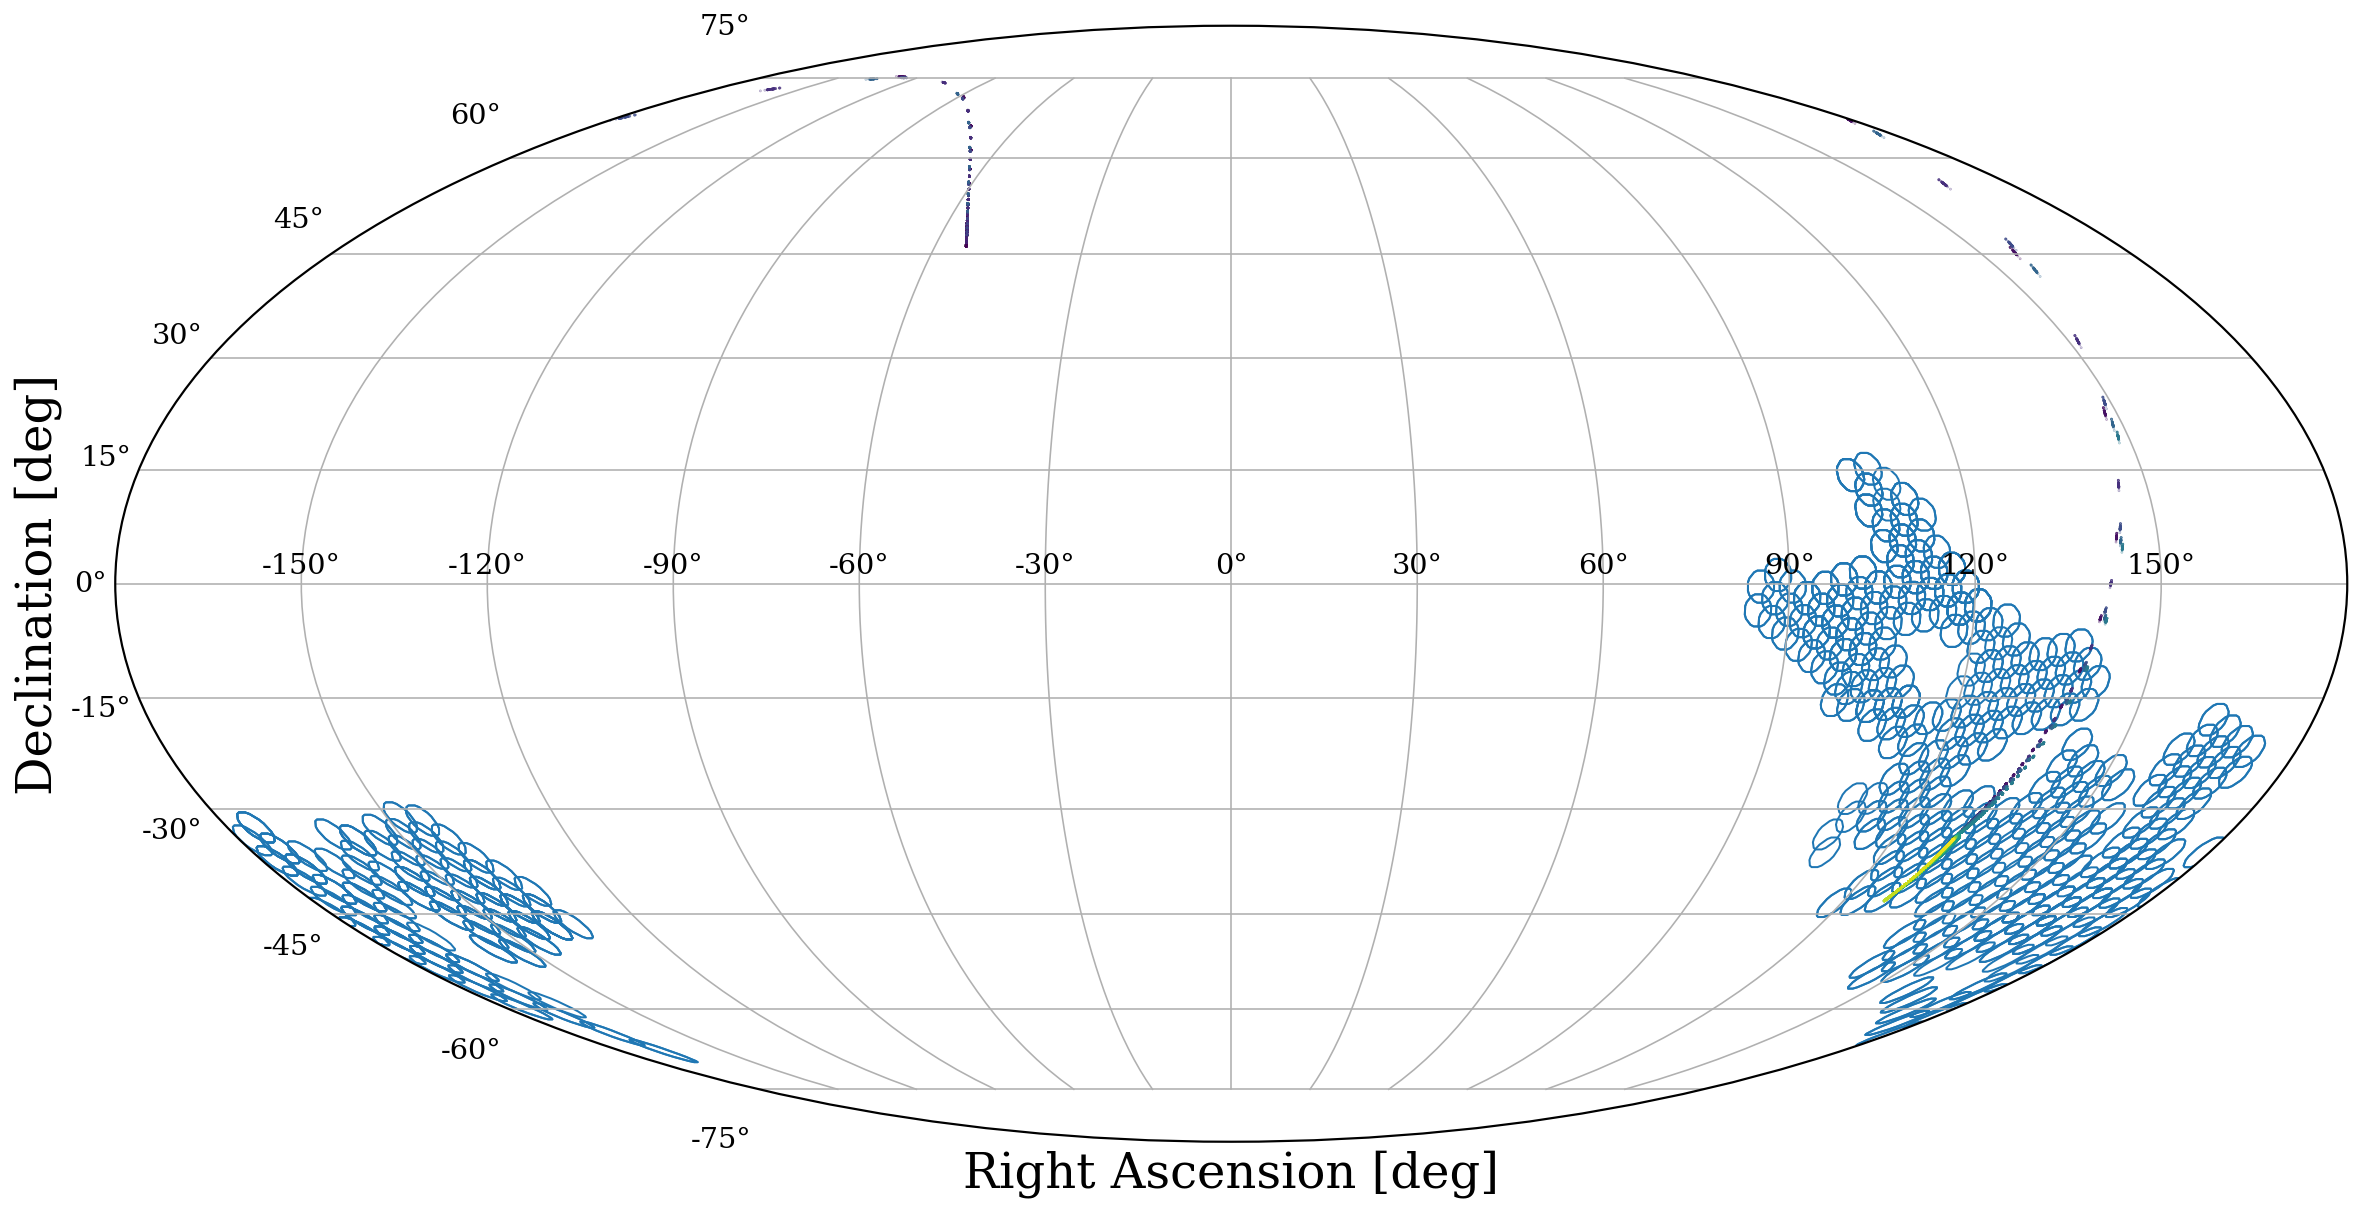

In [270]:
def mollweide_ra_dec(ra, dec):
    deg_to_ra = np.pi / 180
    
    converted_ra = ra * deg_to_ra
    converted_dec = dec * deg_to_ra
    
    converted_ra[converted_ra > np.pi] = converted_ra[converted_ra > np.pi] - 2 * np.pi
    return converted_ra, converted_dec
    

def plot_LSST_schedule_with_orbits_mollweide(df, orbits):
    """Plot LSST schedule up using the dataframe containing fields. Each is assumed to be a circle of radius
    2.1 degrees for simplicity.

    Parameters
    ----------
    df : `pandas DataFrame`
        DataFrame of fields (see `get_LSST_schedule`)
    """
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection="mollweide")

    ra_field, dec_field = mollweide_ra_dec(df["fieldRA"].values, df["fieldDec"].values)
    
    patches = [plt.Circle(center, 2.1 / 180 * np.pi) for center in np.transpose([ra_field, dec_field])]
    coll = PatchCollection(patches, edgecolors='tab:blue', facecolors="none")
    ax.add_collection(coll)
    
    orbit_ra, orbit_dec = mollweide_ra_dec(orbits["RA_deg"].values, orbits["Dec_deg"].values)
    ax.scatter(orbit_ra, orbit_dec, s=0.1, alpha=0.5, c=orbits["orbit_id"])
    
    print(orbit_ra.min(), orbit_dec.min())
    
#     ax.set_aspect("equal")

#     ax.set_xlim(df["fieldRA"].values.min() - 3, df["fieldRA"].values.max() + 3)
#     ax.set_ylim(df["fieldDec"].values.min() - 3, df["fieldDec"].values.max() + 3)

    ax.set_xlabel("Right Ascension [deg]")
    ax.set_ylabel("Declination [deg]")
    
    ax.grid()

    plt.show()

plot_LSST_schedule_with_orbits_mollweide(schedule[schedule["night"] == 14], orbits[orbits["night"] == 14])

## Regular Version

In [313]:
from matplotlib.colors import LogNorm

In [358]:
def plot_LSST_schedule_with_orbits(schedule, reachable_schedule, orbits, night, colour_by="distance", lims="schedule"):
    """Plot LSST schedule up using the dataframe containing fields. Each is assumed to be a circle of radius
    2.1 degrees for simplicity.

    Parameters
    ----------
    df : `pandas DataFrame`
        DataFrame of fields (see `get_LSST_schedule`)
    """
    mask = orbits["night"] == night    
    if len(mask[mask]) == 0:
        print("Warning: No observations in this night")
        return

    fig, ax = plt.subplots(figsize=(20, 10))
    
    for table, colour, lw in zip([schedule, reachable_schedule], ["black", "tab:green"], [1, 2]):
        ra_field, dec_field = table["fieldRA"][table["night"] == night], table["fieldDec"][table["night"] == night]
        patches = [plt.Circle(center, 2.1) for center in np.transpose([ra_field, dec_field])]
        coll = PatchCollection(patches, edgecolors=colour, facecolors="none", linewidths=lw)
        ax.add_collection(coll)
    
    if colour_by == "orbit":
        ax.scatter(orbits["RA_deg"][mask], orbits["Dec_deg"][mask], s=0.5, alpha=1, c=orbits["orbit_id"][mask])
    elif colour_by == "distance":
        scatter = ax.scatter(orbits["RA_deg"][mask], orbits["Dec_deg"][mask], s=0.5, alpha=1, c=orbits["r_au"][mask],
                             norm=LogNorm(vmin=1e-1, vmax=2e1), cmap="magma")
        fig.colorbar(scatter, label="Distance [AU]")
    else:
        raise ValueError("Invalid value for colour_by")
    
    ax.set_aspect("equal")

    if lims in ["schedule", "reachable"]:
        table = schedule if lims == "schedule" else reachable_schedule
        ax.set_xlim(table[table["night"] == night]["fieldRA"].min() - 3, table[table["night"] == night]["fieldRA"].max() + 3)
        ax.set_ylim(table[table["night"] == night]["fieldDec"].min() - 3, table[table["night"] == night]["fieldDec"].max() + 3)

    ax.set_xlabel("Right Ascension [deg]")
    ax.set_ylabel("Declination [deg]")
    
    ax.grid()

    plt.show()

In [43]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [72]:
interact(plot_LSST_schedule_with_orbits, schedule=fixed(schedule), reachable_schedule=fixed(reachable_schedule), orbits=fixed(joined_table),
         night=widgets.IntSlider(min=0, max=14, step=1, value=0, continuous_update=False),
         colour_by=widgets.Combobox(
            value='distance',
            options=['distance', 'orbit'],
            description='Colour by:',
            ensure_option=True,
            disabled=False),
         lims=widgets.Combobox(
            value='orbits',
            options=['orbits', 'schedule', 'reachable'],
            description='Axes limits:',
            ensure_option=True,
            disabled=False)
        )

NameError: name 'plot_LSST_schedule_with_orbits' is not defined

# Weights from Hybrid (TODO)

In [159]:
hybrid = pd.read_hdf("../catalogues/hybrid_cart.h5")

In [163]:
from astropy.coordinates import SkyCoord, get_body

In [217]:
first = 100000

In [269]:
earth = SkyCoord(x=0 * u.AU, y=0 * u.AU, z=0 * u.AU,
         v_x=0 * u.AU / u.s, v_y=0 * u.AU / u.s, v_z=0 * u.AU / u.s,
         frame="gcrs", representation_type="cartesian",
         obstime=Time(59639.0, format="mjd")).transform_to("heliocentriceclipticiau76").represent_as("cartesian")

In [399]:
test = SkyCoord(x=hybrid["x"][:first] * u.AU, y=hybrid["y"][:first] * u.AU,
         z=hybrid["z"][:first] * u.AU,
         v_x=hybrid["vx"][:first] * u.km / u.s, v_y=hybrid["vy"][:first] * u.km / u.s,
         v_z=hybrid["vz"][:first] * u.km / u.s,
         representation_type="cartesian",
         frame="heliocentriceclipticiau76",
         obstime=Time(59639.0, format="mjd")).represent_as("cartesian")

In [191]:
import matplotlib.pyplot as plt

In [400]:
distance = np.sqrt((test.x - earth.x)**2 + (test.y - earth.y)**2 + (test.z - earth.z)**2)

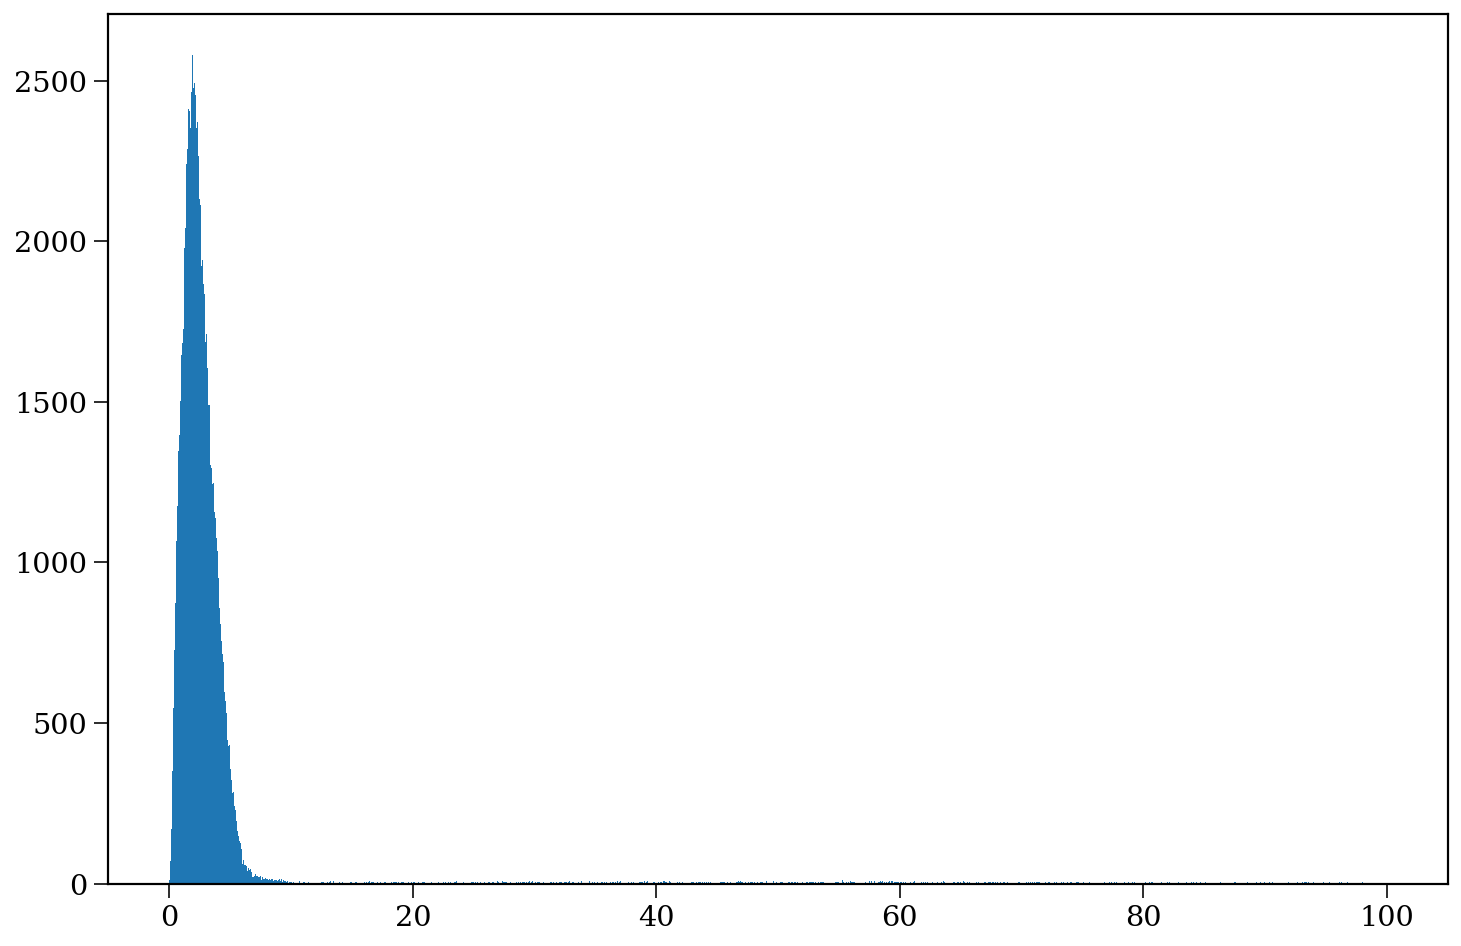

In [401]:
plt.hist(distance.value, range=(0, 100), bins="fd")
plt.show()

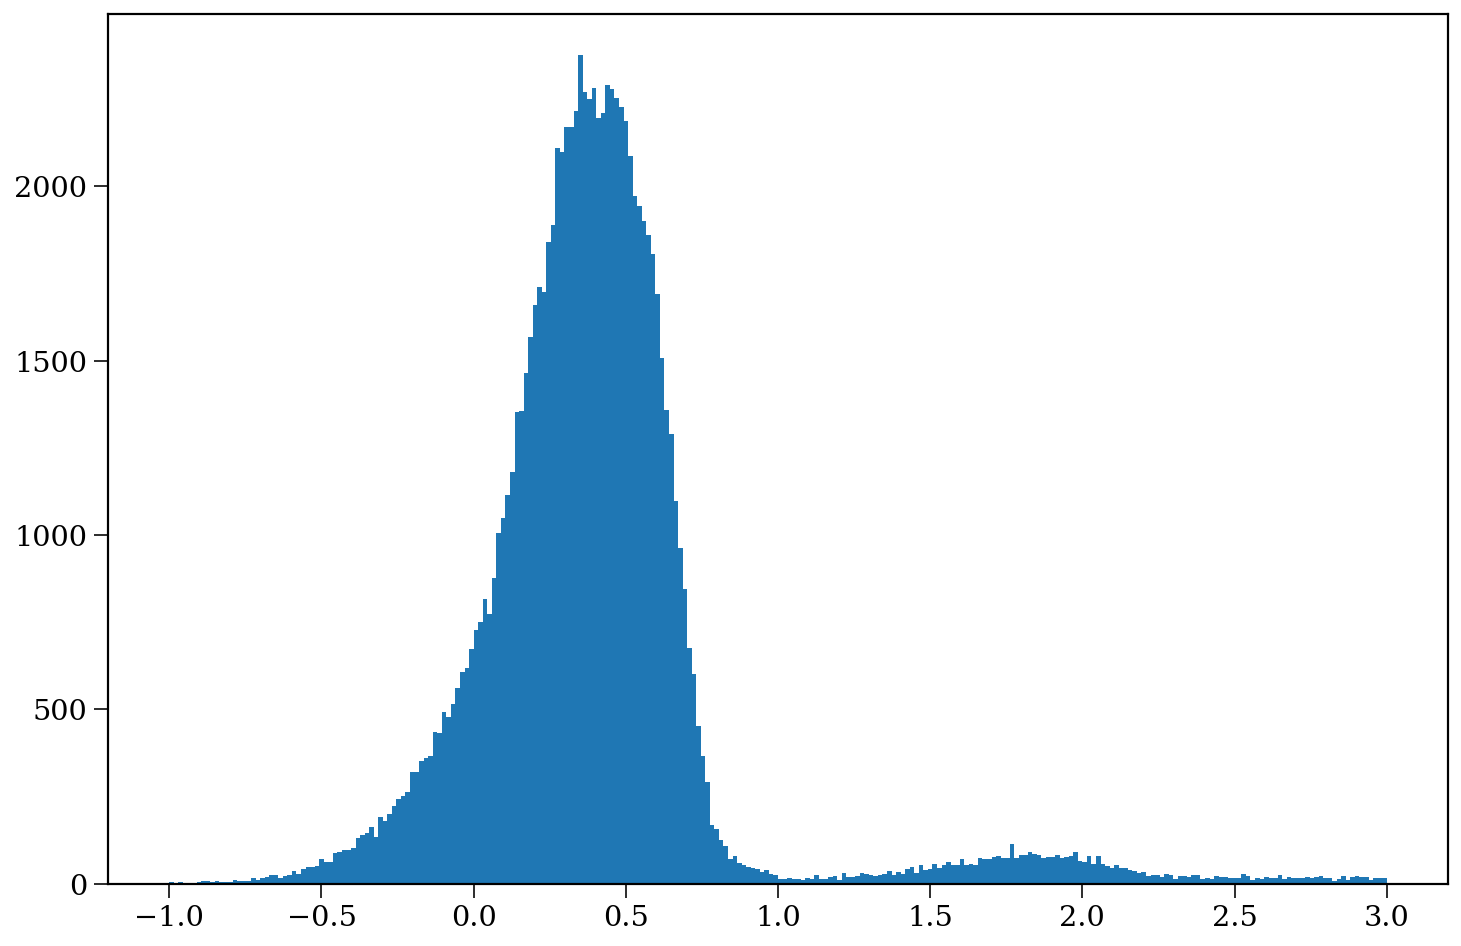

In [402]:
plt.hist(np.log10(distance.value), range=(-1, 3), bins="fd")
plt.show()

In [275]:
rv = (np.sum((test.differentials['s'].d_xyz - earth.differentials["s"].d_xyz[:, None])**2, axis=0)**(0.5)).to(u.km / u.s)

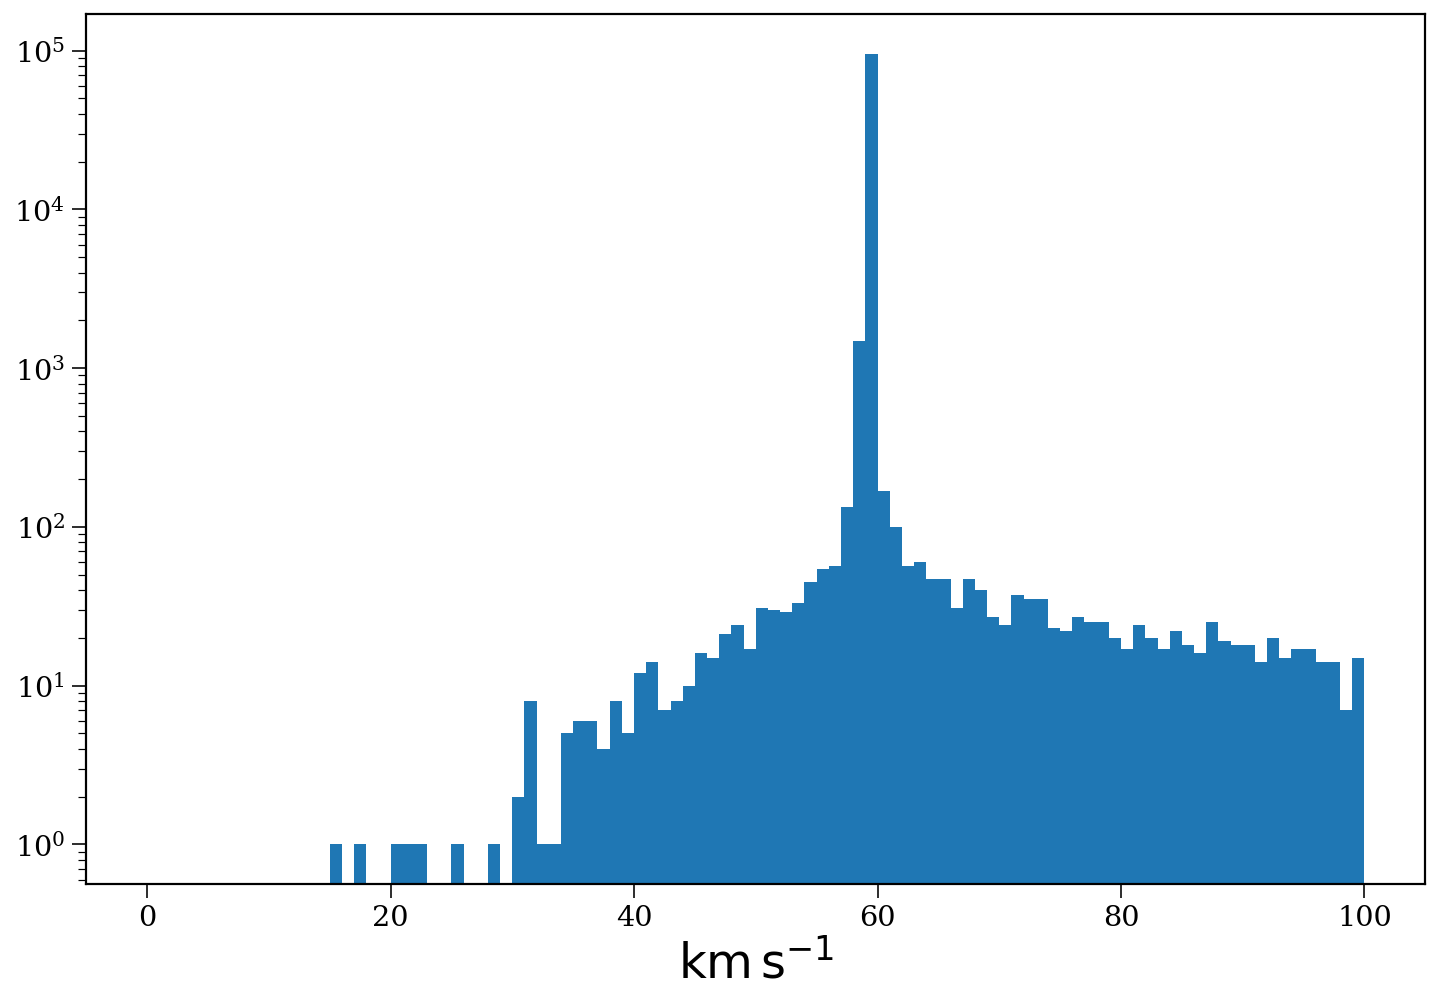

In [277]:
plt.hist(rv, bins=100, range=(0, 100), log=True)
plt.show()